# Exploratory Data Analysis

## Introduction

EDA will continue the effort of predicting MLB pitch types using Statcast data. We start with 61 feature variables and the target variable of 'pitch_type'. Given the high dimensionality of our data, we will be focused on exploring features to potentially drop. Many features are post-pitch data and can not be used to provide meaningful predictions. There will also be a need to transform our data to discover pitch sequences within a single at-bat. 

## Imports and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data_cleaned.csv', index_col='index')

In [3]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
index,,,,,,,,,,,,,,,,,,,,,
1778,SI,2019-07-31,101.0,0.56,6.14,606466.0,547973.0,force_out,hit_into_play,6.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1839,SL,2019-07-31,88.1,0.55,6.24,606466.0,547973.0,NaN,foul,5.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1867,SL,2019-07-31,85.8,0.39,6.13,606466.0,547973.0,NaN,swinging_strike,13.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1932,FF,2019-07-31,96.5,0.72,6.13,572233.0,547973.0,walk,ball,12.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1956,FF,2019-07-31,96.8,0.50,6.16,572233.0,547973.0,NaN,ball,12.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110615 entries, 1778 to 22574
Data columns (total 62 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   pitch_type             110314 non-null  object 
 1   game_date              110615 non-null  object 
 2   release_speed          110327 non-null  float64
 3   release_pos_x          110323 non-null  float64
 4   release_pos_z          110323 non-null  float64
 5   batter                 110615 non-null  float64
 6   pitcher                110615 non-null  float64
 7   events                 28216 non-null   object 
 8   description            110615 non-null  object 
 9   zone                   110323 non-null  float64
 10  stand                  110615 non-null  object 
 11  p_throws               110615 non-null  object 
 12  type                   110615 non-null  object 
 13  hit_location           24620 non-null   float64
 14  bb_type                19165 non-n

## Data Exploration

There are currently an excessive number of feature variables in our dataset based on the [Statcast data dictionary](https://baseballsavant.mlb.com/csv-docs 'Data Dictionary'). We will confirm this and determine the appropriate features by exploring each variable.

### Feature Variables of type 'object'

The [Statcast data dictionary](https://baseballsavant.mlb.com/csv-docs 'Data Dictionary') will be used to help determine which features are insignificant or inapplicable. Starting with 'object' type features, we reserve exploration of our target feature 'pitch_type' and begin with 'game_date'.

In [5]:
data.select_dtypes('object').columns

Index(['pitch_type', 'game_date', 'events', 'description', 'stand', 'p_throws',
       'type', 'bb_type', 'inning_topbot', 'pitch_name',
       'if_fielding_alignment', 'of_fielding_alignment'],
      dtype='object')

'game_date' is the date a game was played and will not determine 'pitch_type'.

In [6]:
data.drop(columns='game_date', inplace=True)

'events' capture the various baseball events that occur within a game. An event does not happen with every pitch; however, 'description' will and it provides a reference to the outcome of each pitch. These features are the first of many that will be inapplicable to the task at hand. Any information gain or result from a pitch is considered post-pitch data and can not be used to help us predict pitch type.

In [7]:
data['events'].value_counts()

field_out                       10907
strikeout                        6522
single                           3999
walk                             2183
double                           1363
home_run                         1057
force_out                         528
grounded_into_double_play         525
hit_by_pitch                      281
field_error                       214
sac_fly                           172
triple                            121
sac_bunt                          104
double_play                        67
fielders_choice                    64
fielders_choice_out                41
strikeout_double_play              24
caught_stealing_2b                 21
catcher_interf                      8
batter_interference                 8
other_out                           1
pickoff_1b                          1
pickoff_caught_stealing_home        1
pickoff_2b                          1
caught_stealing_3b                  1
triple_play                         1
pickoff_3b  

In [8]:
data['description'].value_counts()

ball                       36706
foul                       20130
hit_into_play              19166
called_strike              17882
swinging_strike            11708
blocked_ball                2573
foul_tip                     967
swinging_strike_blocked      895
hit_by_pitch                 281
foul_bunt                    256
missed_bunt                   37
pitchout                      11
bunt_foul_tip                  3
Name: description, dtype: int64

In [9]:
data.drop(columns=['events', 'description'], inplace=True)

'stand' and 'p_throws' reference the batter and pitcher, respectively, and indicates if each is left (L) or right handed (R). Pitchers could be throwing different pitch types based on where the batter stands to face him.

In [10]:
data['stand'].value_counts(normalize=True)

R    0.581856
L    0.418144
Name: stand, dtype: float64

In [11]:
data['p_throws'].value_counts(normalize=True)

R    0.721304
L    0.278696
Name: p_throws, dtype: float64

It's interesting to see the disproportionate mix of R and L between batters and hitters. 

**Do right handed pitchers tend to throw different pitches based on the batter's position?**

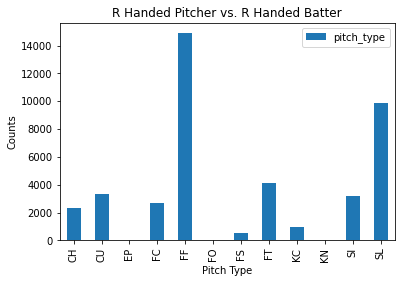

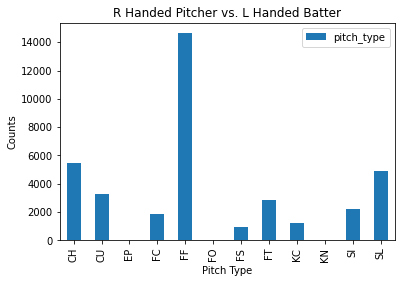

In [12]:
data_RtoR = data[(data['p_throws'] == 'R') & (data['stand'] == 'R')]
val_counts = pd.DataFrame(data_RtoR.pitch_type.value_counts())
val_counts = val_counts.reset_index().sort_values('index')
val_counts.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('R Handed Pitcher vs. R Handed Batter')
plt.xlabel('Pitch Type')
plt.ylabel('Counts')

data_RtoL = data[(data['p_throws'] == 'R') & (data['stand'] == 'L')]
val_counts1 = pd.DataFrame(data_RtoL.pitch_type.value_counts())
val_counts1 = val_counts1.reset_index().sort_values('index')
val_counts1.plot(x = 'index', y = 'pitch_type', kind='bar')

plt.title('R Handed Pitcher vs. L Handed Batter')
plt.xlabel('Pitch Type')
plt.ylabel('Counts')
plt.show()

Right handed (RH) pitchers are throwing fastballs (FF) the most to both sides of the plate, but there's a clear difference betweeen the next most frequent pitch types! A RH batter receives a lot more sliders (SL) than a LH batter while a LH batter will see a changeup (CH) more than any other pitch except fastballs. 

**What about left handed pitchers?**

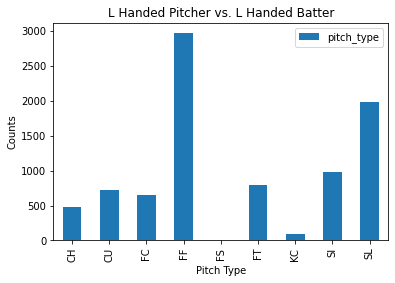

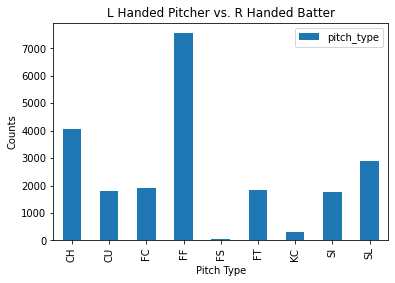

In [13]:
data_LtoL = data[(data['p_throws'] == 'L') & (data['stand'] == 'L')]
val_counts = pd.DataFrame(data_LtoL.pitch_type.value_counts())
val_counts = val_counts.reset_index().sort_values('index')
val_counts.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('L Handed Pitcher vs. L Handed Batter')
plt.xlabel('Pitch Type')
plt.ylabel('Counts')

data_LtoR = data[(data['p_throws'] == 'L') & (data['stand'] == 'R')]
val_counts1 = pd.DataFrame(data_LtoR.pitch_type.value_counts())
val_counts1 = val_counts1.reset_index().sort_values('index')
val_counts1.plot(x = 'index', y = 'pitch_type', kind='bar')

plt.title('L Handed Pitcher vs. R Handed Batter')
plt.xlabel('Pitch Type')
plt.ylabel('Counts')
plt.show()

Not suprisingly, the reciprical is occuring with LH pitchers. This is due to the nature of how pitches move. A slider breaks down and away from a batter of the same orientation which is one of the more desired pitch locations to make a batter miss the ball. Changeups (CH) are again most frequent after fastballs (FF) when the batter is opposite hand of the pitcher.

'type' is a short hand general reference to the result of each pitch: 

- B = ball 
- S = strike 
- X = in play

It won't make sense for us to use 'type' or 'bb_type' as predictors for the 'pitch_type' as these are post-pitch references.

In [14]:
data['type'].value_counts()

S    51879
B    39570
X    19166
Name: type, dtype: int64

'bb_type' indicates the type of batted ball. 'bb_type' will have a value only when 'type' = X (in play).

In [15]:
data['bb_type'].value_counts()

ground_ball    8344
line_drive     4802
fly_ball       4631
popup          1388
Name: bb_type, dtype: int64

In [16]:
data.drop(columns=['type', 'bb_type'], inplace=True)

The last 3 object features indicate the inning and fielding alignment for the infield and outfield. 

In [17]:
data['inning_topbot'].value_counts()

Top    56263
Bot    54352
Name: inning_topbot, dtype: int64

It makes sense to see a smaller count of bottom innings since the bottom of the 9th inning is not played when the home team has more runs than the visiting team. Inning is explored further in the 'float64' features.

In [18]:
data['if_fielding_alignment'].value_counts()

Standard         71739
Infield shift    28271
Strategic        10592
Name: if_fielding_alignment, dtype: int64

In [19]:
data['of_fielding_alignment'].value_counts()

Standard          99249
Strategic         11267
4th outfielder       86
Name: of_fielding_alignment, dtype: int64

It's possible that pitchers are throwing certain pitch types depending on the alignment of the infield. We'll keep all of our object features for now except for 'game_date'. There may be justification later to drop additional object features.

### Feature Variables of type 'float64'

Now we'll begin exploring variables of numeric type.

In [20]:
data.select_dtypes('float64').columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'batter', 'pitcher',
       'zone', 'hit_location', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'hc_x',
       'hc_y', 'fielder_2', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk',
       'pitcher.1', 'fielder_2.1', 'release_pos_y', 'launch_speed_angle',
       'at_bat_number', 'pitch_number', 'home_score', 'away_score',
       'bat_score', 'fld_score', 'post_away_score', 'post_home_score',
       'post_bat_score', 'post_fld_score'],
      dtype='object')

One of two major benefits, and arguably the most valuable, in predicting pitch type is the knowledge of expected pitch speed. The other is ball movement and both are associated with pitch type. The data has reference to 2 speeds: release_speed and effective_speed. The release speed is measured by Statcast as the ball leaves the pitcher's hand, and the effective speed is a derived speed based on the extension of the pitcher's release.

In [21]:
data[['release_speed', 'effective_speed']].describe()

,release_speed,effective_speed
count,110327.000000,110612.000000
mean,88.742331,88.233588
std,5.966305,7.743009
min,50.800000,0.000000
25%,84.500000,84.000000
50%,90.000000,89.700000
75%,93.500000,93.500000
max,102.300000,103.500000


In [22]:
len(data['effective_speed'][data['effective_speed'] == 0])

289

A minimum speed of 0.0 doesn't make sense. Effective speed stats are skewed by 289 zero values so we'll filter for speeds greater than 0.

In [23]:
data.loc[data['effective_speed'] > 0, 'effective_speed'].describe()

count    110323.000000
mean         88.464723
std           6.297918
min          48.500000
25%          84.000000
50%          89.700000
75%          93.500000
max         103.500000
Name: effective_speed, dtype: float64

We can see the release speed and effective speed are very close. Given the definitions of the two speeds, we'll focus on release_speed moving forward.

The plot below is a 2D representation of the catcher's view looking back at the pitcher's mound. Each plotted point represents the release point of a given pitch from the pitcher's hand. Remember that a right handed pitcher is facing the catcher, so their release points will appear on the left while the blue points are released from a left handed pitcher.

Notice the small clusters on each side. These represent the release points of unconventional pitchers known as sidearm pitchers.

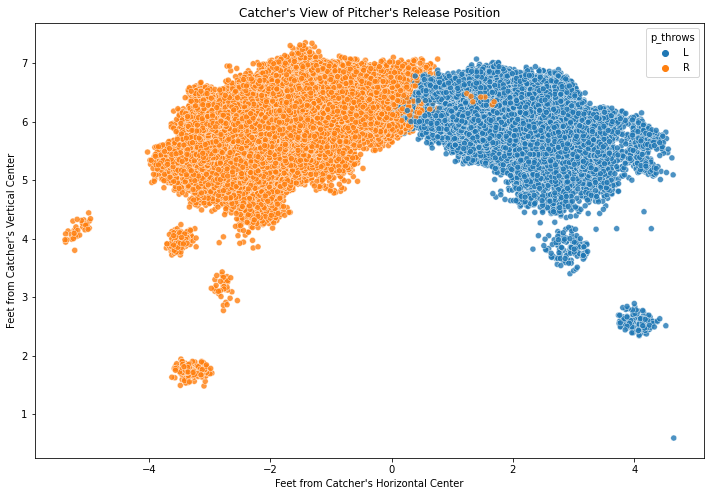

In [24]:
plt.figure(figsize = (12,8))
sns.scatterplot(x='release_pos_x', y='release_pos_z', data=data, hue='p_throws', alpha=0.8)
plt.title('Catcher\'s View of Pitcher\'s Release Position')
plt.xlabel('Feet from Catcher\'s Horizontal Center')
plt.ylabel('Feet from Catcher\'s Vertical Center');

While this is interesting, we can't rely on the speed or position of the pitch to help determine 'pitch_type'. A 100 mph fastball will reach the plate in less than 500 milliseconds. This is obviously not enough time to identify the speed and position, predict the pitch, and communicate the prediction.

In [25]:
data.drop(columns=['release_pos_x', 'release_pos_z', 'effective_speed'], inplace=True)

'batter', 'pitcher', 'on_1b', 'on_2b', 'on_3b', 'fielder_2', 'fielder_2.1', and 'pitcher.1' are all numerical identifiers so descriptive statistics are not meaningful. I suspect that 'fielder_2.1' and 'pitcher.1' are duplicates of 'fielder_2' and 'pitcher', so let's at least see what the stats look like for those:

In [26]:
data[['fielder_2', 'fielder_2.1', 'pitcher', 'pitcher.1']].describe()

,fielder_2,fielder_2.1,pitcher,pitcher.1
count,110615.000000,110615.000000,110615.000000,110615.000000
mean,545935.081842,545935.081842,572594.659793,572594.659793
std,66114.784146,66114.784146,67262.753649,67262.753649
min,425772.000000,425772.000000,282332.000000,282332.000000
25%,488771.000000,488771.000000,519443.000000,519443.000000
50%,547172.000000,547172.000000,592858.000000,592858.000000
75%,595978.000000,595978.000000,621366.000000,621366.000000
max,669257.000000,669257.000000,673633.000000,673633.000000


Confirmed! The fields have identical descriptive statistics and can be considered duplicate columns. 'pitch_name' is also a repetitive, long-hand reference to 'pitch_type' so we'll drop that as well. 

In [27]:
data.drop(columns=['fielder_2.1', 'pitcher.1', 'pitch_name'], inplace=True)

The count of balls, strikes, and outs are fundamental metrics in baseball. For any given pitch, there should be a maximum of 3 balls, 2 strikes, and 2 outs. When a pitch results in a 4th ball, 3rd strike, or 3rd out, the batter changes and the pitch count will reset. We don't see those counts in the data because it is pre-pitch data that we're working with, as desired.

In [28]:
data[['balls', 'strikes', 'outs_when_up']].describe()

,balls,strikes,outs_when_up
count,110615.000000,110615.000000,110615.000000
mean,0.882602,0.901894,0.978782
std,0.968063,0.828099,0.817827
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,3.000000,2.000000,2.000000


In [29]:
data[['balls', 'strikes', 'outs_when_up']].isnull().sum()

balls           0
strikes         0
outs_when_up    0
dtype: int64

These features appear as expected and do not have any null values to address. **What does the pitch type distribution look like for a variety of these features?** We'll answer this question after we transform the data accordingly.

The 'hit_location' is an integer value (1-9) for the position player that first touches the hit ball. 'zone', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'hc_x', 'hc_y', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'release_spin_rate', 'release_extension', 'release_pos_y', 'launch_speed_angle' are all movement, position, or velocity references to the pitch or hit ball. While some of these features will certainly help predict pitch type, it wouldn't be practical for our use as the pitch has to occur in order to gather this information. Our aim is to predict 'pitch_type' with only the information we have before a pitch is thrown.  

In [30]:
data.drop(columns=['hit_location', 'zone', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'hc_x', 'hc_y', 'vx0', 'vy0', 'vz0', 
                   'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 
                   'release_spin_rate', 'release_extension', 'release_pos_y', 'launch_speed_angle'], inplace=True)

Baseball games are played over 9 innings. Each inning has a top and a bottom, indicated in this data by 'inning_topbot'. As mentioned, the bottom of the 9th inning is not always played. The max of 'inning' is greater than 9 because extra innings are played when teams are tied after 9 full innings. Play continues until one of the teams is leading after the bottom of an extra inning. 

In [31]:
data['inning'].describe()

count    110615.000000
mean          5.052850
std           2.707358
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          16.000000
Name: inning, dtype: float64

In [32]:
data['inning'].isnull().sum()

0

'game_pk', 'at_bat_number', and 'pitch_number' are indicators used to differentiate between games, batters, and pitches. They will be very useful in creating pitch sequences for a given at-bat within a specific game. We can also use them to calculate some interesting stats such as the average count of at-bats in a game, or the average count of pitches per at-bat.

In [33]:
data[['game_pk', 'at_bat_number', 'pitch_number']].describe()

,game_pk,at_bat_number,pitch_number
count,110615.000000,110615.000000,110615.000000
mean,566202.750893,39.697889,2.924287
std,834.508178,23.584122,1.747854
min,564777.000000,1.000000,1.000000
25%,565463.000000,19.000000,1.000000
50%,566218.000000,39.000000,3.000000
75%,566913.000000,59.000000,4.000000
max,567608.000000,139.000000,13.000000


'game_pk' is a primary key while 'at_bat_number' and 'pitch_number' are counts. 

**What is the average number of at-bats per game?**

In [34]:
data.groupby('game_pk')['at_bat_number'].agg(max).mean()

77.42896174863388

**What is the minimum number of at-bats in any of the games?**

Note that each team gets a minimum of 3 batters per inning, over 9 innings, for a total of 27 at-bats. We can calculate the minimum allowed by multiplying this by 2 and assuming the very last batter hits a homerun to win the game. This results in 54 at-bats as the absolute lowest possible number in a game of baseball.

In [35]:
data.groupby('game_pk')['at_bat_number'].agg(max).min()

60.0

Pretty close. This game wasn't very exciting for offense as only a handful of players got on base in this game.

**What is the average number of pitches per at-bat?**


In [36]:
data.groupby(['game_pk', 'at_bat_number'])['pitch_number'].agg(max).mean()

3.9148823217129713

Finally, we know that the last 4 object categories starting with 'post_' are post-pitch references and again do not align 
with our intentions.

In [37]:
data.drop(columns=['post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score'], inplace=True)

In [38]:
data.select_dtypes('float64').columns

Index(['release_speed', 'batter', 'pitcher', 'balls', 'strikes', 'on_3b',
       'on_2b', 'on_1b', 'outs_when_up', 'inning', 'fielder_2', 'game_pk',
       'at_bat_number', 'pitch_number', 'home_score', 'away_score',
       'bat_score', 'fld_score'],
      dtype='object')

In [39]:
print(data.columns)
len(data.columns)

Index(['pitch_type', 'release_speed', 'batter', 'pitcher', 'stand', 'p_throws',
       'balls', 'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning',
       'inning_topbot', 'fielder_2', 'game_pk', 'at_bat_number',
       'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score',
       'if_fielding_alignment', 'of_fielding_alignment'],
      dtype='object')


24

We know have less than 30 features plus our target feature. Let's dive into our target feature, 'pitch_type'. We'll see what we can discover within and how 'pitch_type' relates to some other features.

### Target Variable: pitch_type

We start by exploring our target feature, 'pitch_type'. Pitch type is defined as the type of pitch derived from Statcast. It is possible that the Statcast system occasionally misclassifies a pitch type but we may not have a way to determine if and when this happens. The statcast pitch type abbreviations are associated with the following pitch types:

- Changeup (CH)
- Curveball (CU)
- Cutter (FC)
- Eephus (EP)
- Forkball (FO)
- Four-Seam Fastball (FF)
- Knuckleball (KN)
- Knuckle-curve (KC)
- Screwball (SC)
- Sinker (SI)
- Slider (SL)
- Splitter (FS)
- Two-Seam Fastball (FT)

In [40]:
data['pitch_type'].unique()

array(['SI', 'SL', 'FF', 'CH', 'FS', 'FC', 'FT', 'EP', 'CU', 'KC', nan,
       'FO', 'KN'], dtype=object)

Every pitch type except SC (screwball) is represented in the data. This is not surprising given the difficulty of throwing this pitch. In fact, New York Daily News reports no one has thrown a SC in 2019 as of 7/21/19. Our data is from July 2019.

In [41]:
data['pitch_type'].isnull().sum()

301

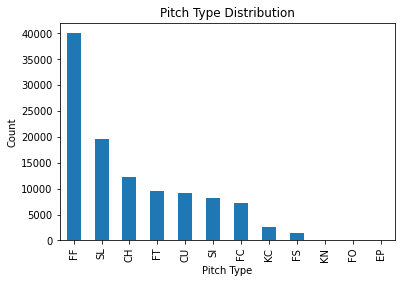

In [42]:
data.pitch_type.value_counts().plot(kind='bar')
plt.title('Pitch Type Distribution')
plt.xlabel('Pitch Type')
plt.ylabel('Count');

FF is the most frequent pitch type with 36.3% of all pitches. SL and CH are the only other types with more than 10% at 17.8% and 11.2% respectively. FT and FF are both fastballs and combine for 45% of all pitches. This will be useful in testing our model as we can compare it to simply guessing fastball for every pitch.

In [43]:
pitch_counts = pd.concat([100 * data['pitch_type'].value_counts(normalize=True).round(3), 
                          data['pitch_type'].value_counts()], axis=1)
pitch_counts.columns = ['%', 'count']
pitch_counts

,%,count
FF,36.3,40020
SL,17.8,19666
CH,11.2,12350
FT,8.7,9638
CU,8.3,9160
SI,7.4,8181
FC,6.5,7153
KC,2.3,2586
FS,1.3,1480
KN,0.0,50


KN, FO, and EP have exceptionally low counts. This is expected as these 3 types of pitches are very difficult to throw and are rarely seen in MLB. Let's take a look at the pitchers that are capable of these pitches.

In [44]:
data.loc[data['pitch_type'] == 'KN', 'pitcher'].unique()

array([453214.])

In [45]:
data.loc[data['pitch_type'] == 'FO', 'pitcher'].unique()

array([571539.])

In [46]:
data.loc[data['pitch_type'] == 'EP', 'pitcher'].unique()

array([425844., 506433.])

One pitcher is responsible for each of the two types KN and FO. Somewhat unexpectedly given a count of 5, the EP pitch type was thrown by 2 different pitchers. The EP (eephus) is an extremely slow pitch that is usually thrown in jest or as an attempt to aggitate your opponent.

## Data Transformation 
We need to transform our data so we can get a sense of the sequences of pitch types a batter will see. Let's start with a subset of the data containing at least our indicator features and pitch type.

In [47]:
basics = data[['game_pk', 'at_bat_number', 'pitch_number', 'pitch_type', 'balls', 'strikes', 'outs_when_up', 'inning', 
               'on_1b', 'on_2b', 'on_3b']]
basics.head()

,game_pk,at_bat_number,pitch_number,pitch_type,balls,strikes,outs_when_up,inning,on_1b,on_2b,on_3b
index,,,,,,,,,,,
1778,567514.0,77.0,3.0,SI,0.0,2.0,2.0,9.0,572233.0,444482.0,NaN
1839,567514.0,77.0,2.0,SL,0.0,1.0,2.0,9.0,572233.0,444482.0,NaN
1867,567514.0,77.0,1.0,SL,0.0,0.0,2.0,9.0,572233.0,444482.0,NaN
1932,567514.0,76.0,4.0,FF,3.0,0.0,2.0,9.0,NaN,444482.0,NaN
1956,567514.0,76.0,3.0,FF,2.0,0.0,2.0,9.0,NaN,444482.0,NaN


Now we need to pivot the data so that there is a sequence of pitch types for each at-bat within a given game.

In [48]:
pitches = pd.pivot(basics, index=['game_pk', 'at_bat_number'], columns='pitch_number', values='pitch_type')

In [49]:
pitches.head()

pitch_number           1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 11.0  \
game_pk  at_bat_number                                                          
564777.0 1.0             CH   CH   CH   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         2.0             FF   SL   FC   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         3.0             SL   FF   FF   FF  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         4.0             SI   FC   CH   CH   KC   FF   FC  NaN  NaN  NaN  NaN   
         5.0             SI  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

pitch_number           12.0 13.0  
game_pk  at_bat_number            
564777.0 1.0            NaN  NaN  
         2.0            NaN  NaN  
         3.0            NaN  NaN  
         4.0            NaN  NaN  
         5.0            NaN  NaN

Now we can create a column that combines all the pitches in an at-bat into a single reference.

In [50]:
pitches['sequence'] = pitches[pitches.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)), axis=1)

In [51]:
pitches.head()

pitch_number           1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0 10.0 11.0  \
game_pk  at_bat_number                                                         
564777.0 1.0            CH   CH   CH   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         2.0            FF   SL   FC   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         3.0            SL   FF   FF   FF  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         4.0            SI   FC   CH   CH   KC   FF   FC  NaN  NaN  NaN  NaN   
         5.0            SI  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

pitch_number           12.0 13.0              sequence  
game_pk  at_bat_number                                  
564777.0 1.0            NaN  NaN           CH,CH,CH,CH  
         2.0            NaN  NaN           FF,SL,FC,CH  
         3.0            NaN  NaN           SL,FF,FF,FF  
         4.0            NaN  NaN  SI,FC,CH,CH,KC,FF,FC  
         5.0            NaN  NaN                    SI

Great! Pitch number column '13.0' aligns with the max we saw in our descriptive statistics for 'pitch_number'. Let's take a look at how many unique combinations of pitch types there are within an at-bat:

In [52]:
pitches['sequence'].value_counts()

FF                         1222
FF,FF                       653
FF,FF,FF                    449
SL                          432
FT                          379
                           ... 
SL,CU,FT,FT,SL                1
FF,FC,FF,CU,CU,CU,FC,FF       1
FF,FF,FS,FF,FS,FF,FS          1
FF,FT,FF,CU                   1
FF,CH,CU,FF,SL,FF,FF,SL       1
Name: sequence, Length: 8401, dtype: int64

8,401 different combinations of pitch type is too many for us to explore individually. Let's take a look at the pitch type distributions for each pitch number, 1 through 13.

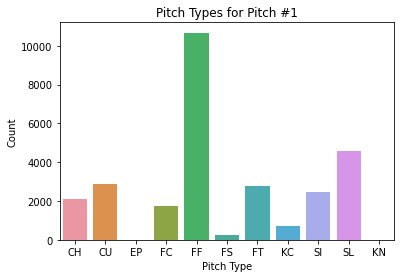

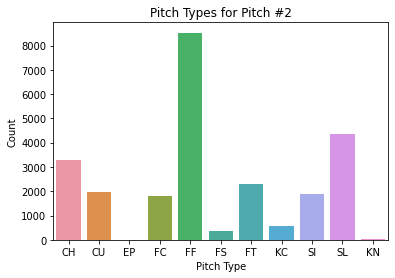

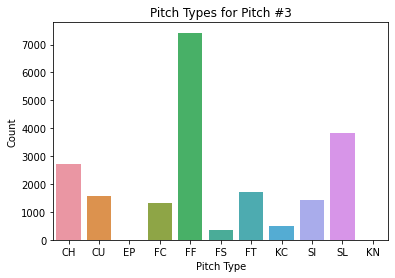

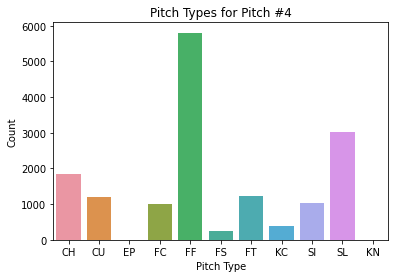

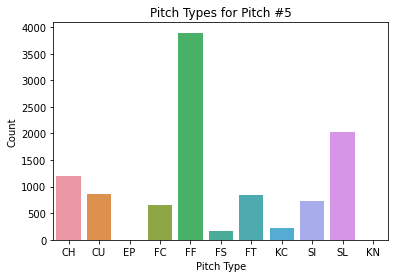

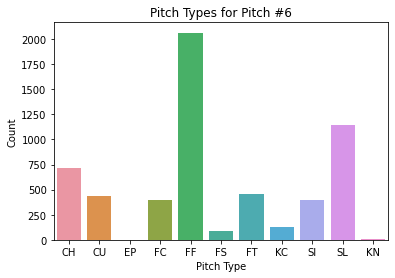

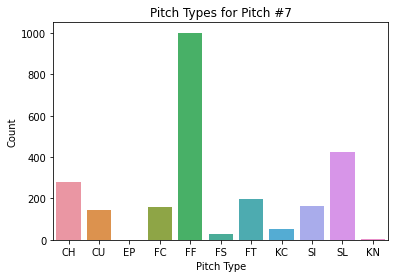

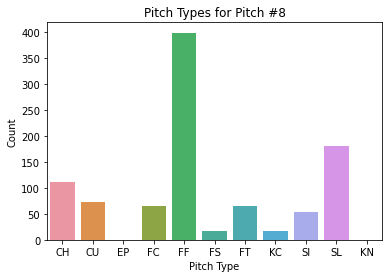

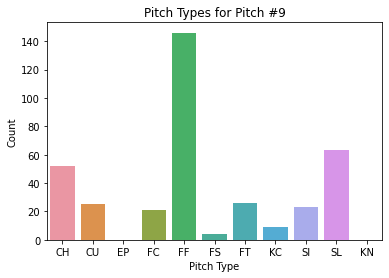

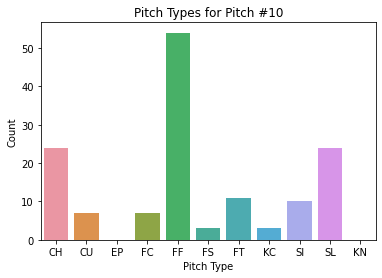

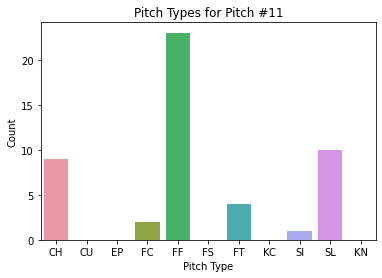

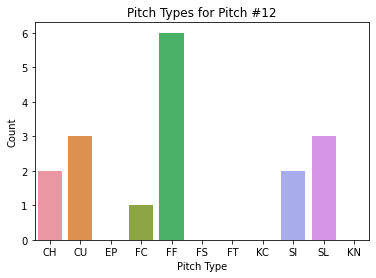

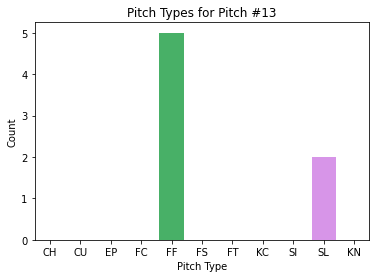

In [53]:
for pitch in range(1,14):
    sns.countplot(x=pitch, data=pitches, order=['CH','CU','EP','FC','FF','FS','FT','KC','SI','SL','KN'])
    plt.title(f'Pitch Types for Pitch #{pitch}')
    plt.xlabel('Pitch Type')
    plt.ylabel('Count')
    plt.show();

It is interesting to see a very similar relative distribution of pitch type for any of the pitches numbered 1 through 10. Based on this information, in addition to the high count of unique combinations, we will move forward with treating each pitch type as independent from the previous pitch type. This assumption will also make it more practical for working with the data that we have.  

## Speed vs. Pitch Type

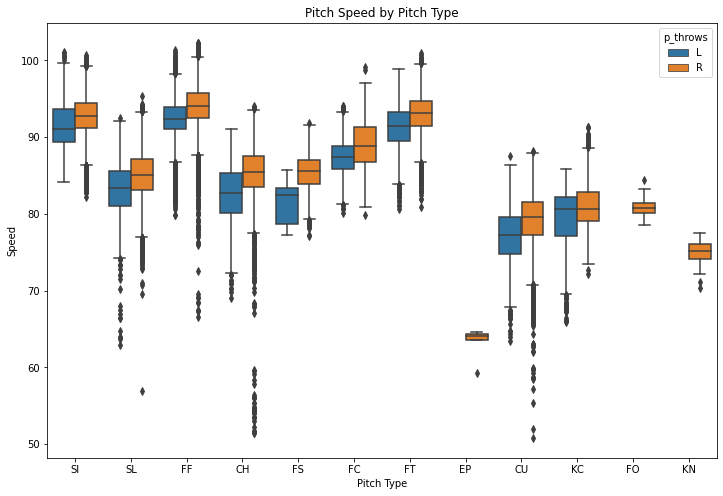

In [54]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='pitch_type', y='release_speed', hue='p_throws', data=data)
plt.title('Pitch Speed by Pitch Type')
plt.xticks(rotation='horizontal')
plt.ylabel('Speed')
plt.xlabel('Pitch Type');

Here we can see how speed varies by pitch type. A batter's swing timing will depend on the speed of the pitch. The box plot above shows how a fastball (FF & FT) is much faster than a slider (SL) or changeup (CH). Note that right handed pitchers tend to throw faster pitches for all pitch types. They also have a larger range, especially on the slow end, than left handed pitchers. The range is most likely due to the higher count of right handers.

Pitch speed is not pre-pitch data, so it won't be used to predict 'pitch_type'. Instead, this illustrates some of the value in predicting pitch type as a batter can be better prepared for the timing of his swing.

## Balls, Strikes, and Outs vs. Pitch Type

A couple significant features expected to affect the pitch type is the count of balls and strikes. Recall that for any given pitch, there will never be more than 3 balls or 2 strikes. A 4th ball results in a base on balls and the batter goes to 1st base. A 3rd strike results in a strike out and will retire the batter and add 1 to the count of outs. We can look at 2 extreme examples: 

1. All pitches where the count is 3 balls and 0 strikes
2. All pitches where the count is 0 balls and 2 strikes 

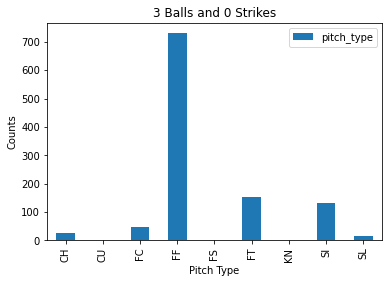

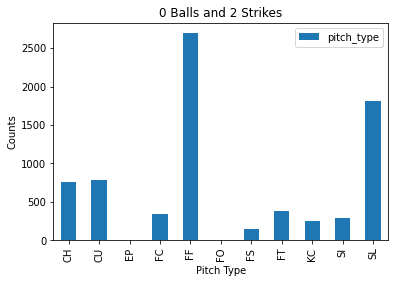

In [55]:
_30count = basics[(basics['balls'] == 3.0) & (basics['strikes'] == 0.0)]
val_counts = pd.DataFrame(_30count.pitch_type.value_counts())
val_counts = val_counts.reset_index().sort_values('index')
val_counts.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('3 Balls and 0 Strikes')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

_02count = basics[(basics['balls'] == 0.0) & (basics['strikes'] == 2.0)]
val_counts1 = pd.DataFrame(_02count.pitch_type.value_counts())
val_counts1 = val_counts1.reset_index().sort_values('index')
val_counts1.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('0 Balls and 2 Strikes')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

The plots above align with my expectations. When a pitcher is throwing his 4th pitch with 3 balls and 0 strikes, he wants to be certain to throw a strike in order to avoid putting the batter on base. This is why we see a large majority of the pitches as type FF or FT, both fastballs, in the first plot. The second plot shows a greater variety of pitch types with slider (SL) having a significant count. This is because the pitcher has an advantage with 2 strikes and can throw a more aggressive pitch in an attempt to make the batter swing at strike 3. 

**What about somewhere in the middle like 2 balls and 1 strike? What does the distribution look like for a full count (3 balls and 2 strikes)?**

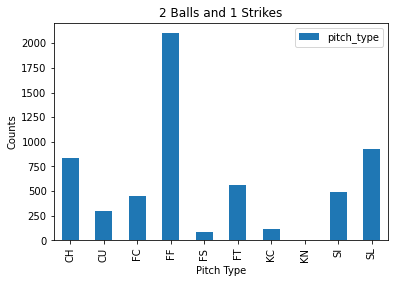

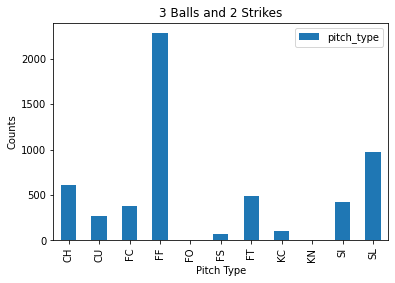

In [56]:
_21count = basics[(basics['balls'] == 2.0) & (basics['strikes'] == 1.0)]
val_counts = pd.DataFrame(_21count.pitch_type.value_counts())
val_counts = val_counts.reset_index().sort_values('index')
val_counts.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('2 Balls and 1 Strikes')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

_32count = basics[(basics['balls'] == 3.0) & (basics['strikes'] == 2.0)]
val_counts1 = pd.DataFrame(_32count.pitch_type.value_counts())
val_counts1 = val_counts1.reset_index().sort_values('index')
val_counts1.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('3 Balls and 2 Strikes')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

Almost identical and very similar to the distributions we saw by pitch number. Let's see if the 3 balls, 2 strikes distribution looks any different with no outs compared to 2 outs.

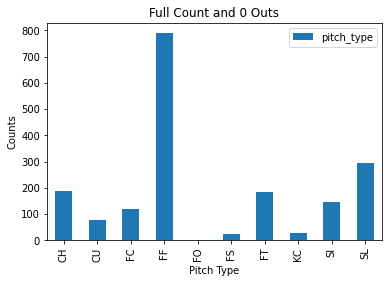

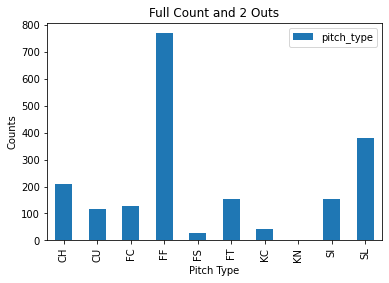

In [57]:
_0outs = basics[(basics['balls'] == 3.0) & (basics['strikes'] == 2.0) & (basics['outs_when_up'] == 0.0)]
val_counts = pd.DataFrame(_0outs.pitch_type.value_counts())
val_counts = val_counts.reset_index().sort_values('index')
val_counts.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('Full Count and 0 Outs')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

_2outs = basics[(basics['balls'] == 3.0) & (basics['strikes'] == 2.0) & (basics['outs_when_up'] == 2.0)]
val_counts1 = pd.DataFrame(_2outs.pitch_type.value_counts())
val_counts1 = val_counts1.reset_index().sort_values('index')
val_counts1.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('Full Count and 2 Outs')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

No meaningful difference and they continue to align with the previous plots. One last distribution to explore is for all pitch counts with 0 outs compared to 2 outs.

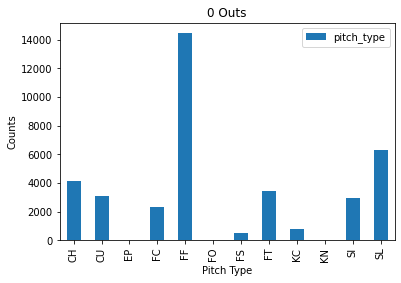

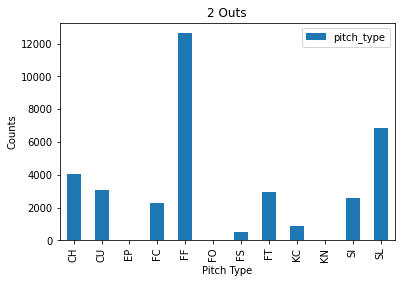

In [58]:
_0outs = basics[(basics['outs_when_up'] == 0.0)]
val_counts = pd.DataFrame(_0outs.pitch_type.value_counts())
val_counts = val_counts.reset_index().sort_values('index')
val_counts.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('0 Outs')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

_2outs = basics[(basics['outs_when_up'] == 2.0)]
val_counts1 = pd.DataFrame(_2outs.pitch_type.value_counts())
val_counts1 = val_counts1.reset_index().sort_values('index')
val_counts1.plot(x = 'index', y = 'pitch_type', kind='bar')
 
plt.title('2 Outs')
plt.xlabel('Pitch Type')
plt.ylabel('Counts');

Once again, there is a minimal difference. The two extreme cases of 3 balls, 0 strikes and 0 balls, 2 strikes are the only distributions with an evident variance in pitch type frequencies.

Now that we have decided to treat each pitch as independent from other pitches, we can drop the 301 observations with null values for 'pitch_type' without impacting the other pitches in the respective at-bat. There are also a few observations of fielding alignments that have null values. Given the large quantity of data we are working with, we will drop these rows as well. The on_(x)b features are expected to have large values for null as there are rarely runners on base.

In [59]:
data.isnull().sum()

pitch_type                  301
release_speed               288
batter                        0
pitcher                       0
stand                         0
p_throws                      0
balls                         0
strikes                       0
on_3b                    100659
on_2b                     90384
on_1b                     77477
outs_when_up                  0
inning                        0
inning_topbot                 0
fielder_2                     0
game_pk                       0
at_bat_number                 0
pitch_number                  0
home_score                    0
away_score                    0
bat_score                     0
fld_score                     0
if_fielding_alignment        13
of_fielding_alignment        13
dtype: int64

In [60]:
data.dropna(subset=['pitch_type', 'release_speed', 
                                    'if_fielding_alignment', 'of_fielding_alignment'], inplace=True)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110301 entries, 1778 to 22574
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   pitch_type             110301 non-null  object 
 1   release_speed          110301 non-null  float64
 2   batter                 110301 non-null  float64
 3   pitcher                110301 non-null  float64
 4   stand                  110301 non-null  object 
 5   p_throws               110301 non-null  object 
 6   balls                  110301 non-null  float64
 7   strikes                110301 non-null  float64
 8   on_3b                  9954 non-null    float64
 9   on_2b                  20207 non-null   float64
 10  on_1b                  33042 non-null   float64
 11  outs_when_up           110301 non-null  float64
 12  inning                 110301 non-null  float64
 13  inning_topbot          110301 non-null  object 
 14  fielder_2              110301 non-

## Summary

We started the EDA process by loading our previously wrangled data containing over 60 features and 110k observations. Exploration of all features resulted in 38 of the features being dropped. We also dropped a few hundred observations that contained at least 1 null value in 4 of the remaining features. The dropped features were almost entirely due to the nature of our prediction interest. Rather than simply demonstrating predictive power, we want to predict pitch types with the information available in between pitches and with enough time to hypothetically communicate this predictions to a batter. This means that any information gained from the pitch of interest can not be used. For example, we can't use the speed, spin, or position of a pitch to predict the pitch with our intent.

During our exploration of which arm a pitcher throws with compared to the position of the batter, we discovered meaningful differences in the pitch type distributons for same hand vs. opposite hand combinations. Specifically, when a right handed pitcher throws to a right handed batter, we see a higher count of sliders and lower count of changeups. The same is true for left handed pitchers throwing to left handed batters. We also found the count of balls, strikes, and outs to have minimal effect on the pitch type distributions except for extreme cases such as 3 balls, 0 strikes and 0 balls, 2 strikes. Finally, we transformed the data to allow for discovery of pitch sequences within at-bats. The very high count of unique combinations, combined with consistent pitch type distributions for any given pitch number in sequence, allowed us comfort in moving forward with pitches remaining as independent events.

As we move into preprocessing, we will need to create dummy variables, apply feature scaling, and split the data into train and test sets.

In [62]:
data.head().T

index,1778,1839,1867,1932,1956
pitch_type,SI,SL,SL,FF,FF
release_speed,101.0,88.1,85.8,96.5,96.8
batter,606466.0,606466.0,606466.0,572233.0,572233.0
pitcher,547973.0,547973.0,547973.0,547973.0,547973.0
stand,R,R,R,R,R
p_throws,L,L,L,L,L
balls,0.0,0.0,0.0,3.0,2.0
strikes,2.0,1.0,0.0,0.0,0.0
on_3b,NaN,NaN,NaN,NaN,NaN
on_2b,444482.0,444482.0,444482.0,444482.0,444482.0


In [63]:
pwd

'C:\\Users\\Louie\\GitHub\\Capstone2_Project'

In [64]:
#data.to_csv(r'C:\\Users\\Louie\\GitHub\\Capstone2_Project\baseball_features.csv, index=False)